In [1908]:
import scipy.stats as st
import sys

# Add path to list of known working paths for Python 
sys.path.append('/Users/mattesa/ZenBook/Python/PLS-DA')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)


# ****************************************************************************
#    PARAMETERS for modelling cross validation
# ****************************************************************************
# Column name for the response variable to use in PLS-DA
unique_PID   = "PatientID"
Response_Col = "hormornbeh"
timepoint    = 5

fold_save    = "Survival"
data_type    = "LP"

# Double cross validation parameters 
outer_N_loops = 20
inner_N_loops = 10
max_N_LV = 10
# Fraction of test-to-train to use
outer_FractSele = 0.20     
inner_FractSele = 0.20    
# Categories (/level) to use to create two group based on response variable 
min_cat    = 0
max_cat    = 1
# Transform categories into 0 and 1 values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold

             
# ****************************************************************************
#    SELECTION of observation groups for modelling
# ****************************************************************************
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
# Chose the dataset according to the data_type
if   data_type == "LP":
    dataset = LP_measure               
elif data_type == "MB":
    dataset = MB_measure 
elif data_type == "LP-MB":
    dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
    
# Select only samples from a specific time point
mask = YY["Timepoint_kodet"]== 5
YY = YY.loc[mask]
dataset = dataset.loc[mask]

# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]


# Display how many sample there are for each category.
col_name = "Status_code"
data_column = YY[Response_Col]
categ = [min_cat, max_cat]
for cc in categ:
    tot = ( data_column == cc).sum()
    print(cc, " - ",  tot)

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat], transform_cat ) 

0  -  64
1  -  83


Iteration:   : 20 of 20

Mode num. LV:  2.0
Accuracy    :  0.63  ( 0.6028, 0.6605 )


,Mean
Accuracy,0.631667
Specificity,0.496154
Sensitivity,0.735294
Best_nLV,3.150000


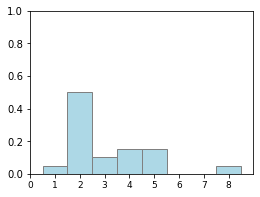

In [1913]:
# --- 2 --- Cross-validation of PLS ------------------------------------------
# Outer
#   Inner
#     number LV
PerfoMetric, comparPred, outerCAL, totalCAL, optimal_nLV = optimise_PLS_CrossVal(
                        XX, YY, max_N_LV, unique_PID,
                        Response_Col, min_rval, max_rval, p_threshold , 
                        outer_N_loops, inner_N_loops, outer_FractSele, inner_FractSele,
                        True)
# Calculate the Accuracy CI (confidence intervals)
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

# Visuallize key results on accuracy and optimal LV number
print("\n")
print("Mode num. LV:  " + str(optimal_nLV) )
PerfoMetric["Mean"] = PerfoMetric.mean(axis=1)
print("Accuracy    :  " + str(round( PerfoMetric.mean(axis=1)["Accuracy"], 2))
                        + "  ( " +str(round(CI[0],4))+", "+str(round(CI[1],4))+ " )" ) 

pd.DataFrame( PerfoMetric["Mean"] )

# plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

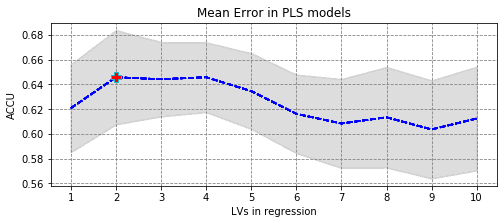

In [1911]:
plot_metrics( outerCAL.T.values , 'ACCU', 'max', True)

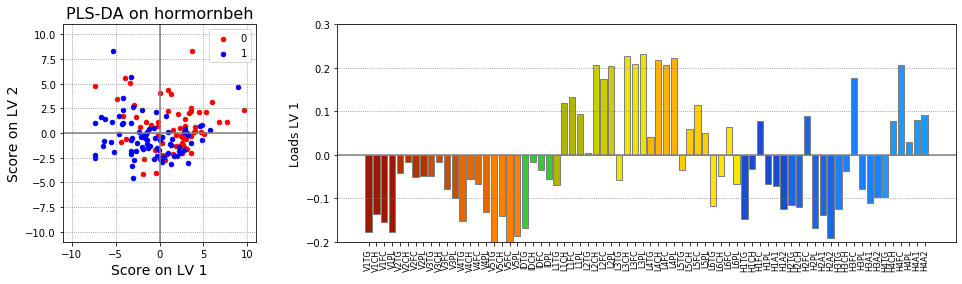

In [1917]:
## ************************************************************
#                          O-PLS
# ************************************************************

from pyopls import *
# Create the class OPLS, with the LV to orthogonalize into the first component 
# that was found from perfoming PLS cross validation
opls = OPLS( int(optimal_nLV) )
# Fit the model to the data, then get the non-orthogonal components of X 
# i.e. Learn and apply filtering on the training data and get the filtered X, 
# which is called variable Z in the code
Z  = opls.fit_transform( XX, YY[Response_Col])
ZZ_opls = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( XX, YY.loc[:, Response_Col], 6, False)


# --- PLOT
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [5, 16]})


plot_ScoresPLS( X_scores, YY, Response_Col, [min_cat,max_cat] , ax1)

plot_LoadingsPLS( X_loads, YY, Response_Col, [min_cat,max_cat], vars_order, vars_color, 1, ax2)
fig.tight_layout()

In [1849]:
# Set the variables names and colors based on the data_type used for the model
data_type = "LP"
if  data_type == "LP":
    vars_order = [  
                    'V1TG', 'V1CH', 'V1FC', 'V1PL', 
                    'V2TG', 'V2CH', 'V2FC', 'V2PL', 
                    'V3TG', 'V3CH', 'V3FC', 'V3PL', 
                    'V4TG', 'V4CH', 'V4FC', 'V4PL', 
                    'V5TG', 'V5CH', 'V5FC', 'V5PL', 

                    'IDTG', 'IDCH', 'IDFC', 'IDPL',

                    'L1TG', 'L1CH', 'L1FC', 'L1PL',
                    'L2TG', 'L2CH', 'L2FC', 'L2PL',
                    'L3TG', 'L3CH', 'L3FC', 'L3PL',
                    'L4TG', 'L4CH', 'L4FC', 'L4PL',
                    'L5TG', 'L5CH', 'L5FC', 'L5PL',
                    'L6TG', 'L6CH', 'L6FC', 'L6PL',

                    'H1TG', 'H1CH', 'H1FC', 'H1PL', 'H1A1', 'H1A2',
                    'H2TG', 'H2CH', 'H2FC', 'H2PL', 'H2A1', 'H2A2',
                    'H3TG', 'H3CH', 'H3FC', 'H3PL', 'H3A1', 'H3A2',
                    'H4TG', 'H4CH', 'H4FC', 'H4PL', 'H4A1', 'H4A2',
                    ]

    # Create a concatenated list of RGB values to assign vars_MB_order colors 
    # NOTE 1 : use * operator for list concatenation and *n for repeation
    # NOTE 2 : the indexes of the DF (variables) )were reorganized before based on vars_LP_order list
    vars_color = [*[[.6,.1,.0]]*4 , *[[.7,.2,.0]]*4 , *[[.8,.3,.0]]*4 , *[[.9,.4,.0]]*4, *[[1 ,.5,.0]]*4,
                  *[[.2,.8,.2]]*4 , 
                  *[[.7,.7,.0]]*4 , *[[.8,.8,.0]]*4 , *[[.9,.9,.0]]*4 , 
                  *[[1.,.7,.0]]*4 , *[[1.,.8,.0]]*4 , *[[1.,.9,.0]]*4 ,
                  *[[.1,.3,.8]]*6 , *[[.1,.4,.9]]*6 , *[[.1,.5,1.]]*6 , *[[.1,.6,1.]]*6,
    ]   
    
    
elif data_type == "MB":    
    vars_order = [  
                    'Lysine', 'Histidine', 'Glutamic acid',
                    'Glutamine', 'Asparagine', 'Threonine', 
                    'Glycine', 'Proline',
                    'Phenylalanine', 'Leucine', 'Alanine', 'Tyrosine', 'Valine', 'Isoleucine', 'Methionine',                  
                    'N,N-Dimethylglycine', 'Ornithine', 'Sarcosine',                 
                    '2-Hydroxybutyric acid', '3-Hydroxybutyric acid', '2-Oxoglutaric acid', '2-Aminobutyric acid',
                    'Pyruvic acid', 'Citric acid', 'Acetic acid', 'Lactic acid', 'Succinic acid', 'Formic acid', 'Acetoacetic acid',                  
                    'K-EDTA','Ca-EDTA',                 
                    'Acetone', 'Glycerol',                 
                    'D-Galactose', 'Glucose',                 
                    'Dimethylsulfone',                   
                    'Choline', 'Creatine', 'Creatinine'
                 ]
    # Create a concatenated list of RGB values to assign vars_MB_order colors 
    # NOTE 1 : use * operator for list concatenation and *n for repeation
    # NOTE 2 : the indexes of the DF (variables) )were reorganized before based on vars_MB_order list
    vars_color = [*[[0,0.6,1]]*3 , *[[0, 0.4, 1]]*3 , *[[0, 0.2, 1]]*2 , *[[0, 0, 1]]*7,
                  *[[1,0.8,0.2]]*3 , 
                  *[[1,0.4,0.2]]*4 , 
                  *[[1,0.0,0.2]]*7 , 
                  *[[0.2, 0.5, 0.2]]*2 , *[[0.1, 0.6, 0.1]]*2 , *[[0.0, 0.6, 0.0]]*2 , *[[.8, .8, 0]]*1, *[[0, 0.7, 0.2]]*3 ] 

"""    
R = []
G = []
B = []
for xx in vars_color:
    R.append( xx[0] )
    G.append( xx[1] )
    B.append( xx[2] )

tableVars_Order_RGB = pd.DataFrame(data = np.array([vars_order, R, G, B]).T, columns = ["LP_names", "R", "G", "B"])
tableVars_Order_RGB
# --_ SAVE --- Save as Python-Ready .csv file
tableVars_Order_RGB.to_csv( root_path + "/table"+data_type+"_Order_RGB.csv", header=True, index=True)
"""

'    \nR = []\nG = []\nB = []\nfor xx in vars_color:\n    R.append( xx[0] )\n    G.append( xx[1] )\n    B.append( xx[2] )\n\ntableVars_Order_RGB = pd.DataFrame(data = np.array([vars_order, R, G, B]).T, columns = ["LP_names", "R", "G", "B"])\ntableVars_Order_RGB\n# --_ SAVE --- Save as Python-Ready .csv file\ntableVars_Order_RGB.to_csv( root_path + "/table"+data_type+"_Order_RGB.csv", header=True, index=True)\n'

In [1916]:
int(optimal_nLV)

2